# FOMO - Faster Objects, More Objects

## Imports

In [39]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Resize
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchmetrics import MetricCollection, MeanAbsoluteError, MeanSquaredError
from torchmetrics.classification import BinaryF1Score

import pytorch_lightning as pl
from pytorch_lightning.loggers import MLFlowLogger

from monai.losses.dice import DiceLoss

## Dataset

#### Dataset parameters

In [40]:
DATASET_DIR = Path("../Datasets/Crossroad")
TEST_DATASET = False
NUMBER_OF_CLASSES = 1

CLASSES = {
    "car": 0
}

#### Convert bounding boxes labels to centroid masks

In [41]:
class BoundingBoxToMask:
    """
    Convert YOLO bounding boxes to FOMO centroids. Used in label processing.
    Return mask of centroids and number of objects in mask.
    """
    def __init__(self, image_resolution: int, grid_scale: int, number_of_classes: int):
        self._image_resolution = image_resolution
        self._grid_scale = grid_scale
        self._number_of_classes = number_of_classes

    def __call__(self, label):
        grid_resolution = int(self._image_resolution / self._grid_scale)

        masks = []
        count = []
        for i in range(self._number_of_classes):
            class_mask = torch.zeros((grid_resolution, grid_resolution), dtype=float)
            bounding_boxes = label.readlines()
            for bounding_box in bounding_boxes:
                [c, x, y, _, _] = [
                    float(coords) for coords in bounding_box.split()
                ]  # get bounding box class, position and dimension
                if c == i:
                    x = int(x * grid_resolution)
                    y = int(y * grid_resolution)
                    class_mask[y, x] = 1.0
            masks.append(class_mask)
            count.append(len(bounding_boxes))

        return torch.stack(masks), count

#### Dataset class

In [42]:
class VehicleDataset(Dataset):
    def __init__(
        self,
        dataset_dir: Path,
        transform=None,
        target_transform=None,
    ):
        self._images = sorted([
            element for element in (dataset_dir / Path("images")).iterdir()
        ])
        self._labels = sorted([
            element for element in (dataset_dir / Path("bounding_boxes")).iterdir()
        ])
        self._transform = transform
        self._target_transform = target_transform

    def __getitem__(self, idx: int):
        image_path = self._images[idx]
        image = read_image(str(image_path))
        image = self._transform(image.float())

        label_path = self._labels[idx]
        label_file = open(label_path)
        centroid_mask, count = self._target_transform(label_file)

        return image, centroid_mask, count

    def __len__(self):
        return len(self._images)

#### DataModule class

In [43]:
class VehicleDataModule(pl.LightningDataModule):
    def __init__(
        self,
        dataset_dir: Path,
        input_resolution: int,
        grid_scale: int,
        batch_size: int,
    ):
        super().__init__()
        self._dataset_dir = dataset_dir
        self._input_resolution = input_resolution  
        self._grid_scale = grid_scale
        self._batch_size = batch_size
 
        self._transform = Resize((input_resolution, input_resolution), antialias=True)
        self._target_transform = BoundingBoxToMask(input_resolution, grid_scale, NUMBER_OF_CLASSES)
        self._train_dataset = None
        self._val_dataset = None
        self._test_dataset = None
        self._test_dataset = None

    def setup(self, stage: str):
        self._train_dataset = VehicleDataset(
            self._dataset_dir / Path("training"),
            self._transform,
            self._target_transform,
        )
        self._val_dataset = VehicleDataset(
            self._dataset_dir / Path("validation"),
            self._transform,
            self._target_transform,
        )
        self._test_dataset = VehicleDataset(
            self._dataset_dir / Path("test" if TEST_DATASET else "validation"),
            self._transform,
            self._target_transform,
        )

    def train_dataloader(self):
        return DataLoader(self._train_dataset, batch_size=self._batch_size, num_workers=7)
    
    def val_dataloader(self):
        return DataLoader(self._val_dataset, batch_size=self._batch_size, num_workers=7)

    def test_dataloader(self):
        return DataLoader(self._test_dataset, batch_size=self._batch_size, num_workers=7)

## FOMO Model

#### Model parameters

In [44]:
GRID_SCALE = 8
DETECTION_THRESHOLD = 0.1

#### FOMO network architecture

In [45]:
def fomo_net(weights: None, number_of_classes: int) -> nn.Module:
    """
    Constructs a FOMO net model with a specified number of classes.
    Input resolution is decreased by a factor of GRID_SCALE.
    """
    fomo_cut = {
        2 : {
            "cut_layer": 2,
            "channels": 16
        },
        4 : {
            "cut_layer": 4,
            "channels": 24
        },
        8 : {
            "cut_layer": 7,
            "channels": 32
        },
        16 : {
            "cut_layer": 14,
            "channels": 96
        },
    }

    model = mobilenet_v2(weights=weights)
    # Remove layers after 1/GRID_SIZE reduction
    cut_inverted_residual = fomo_cut[GRID_SCALE]['cut_layer']
    features = [
        nn.Identity() if i > cut_inverted_residual else model.features[i]
        for i, _ in enumerate(model.features)
    ]
    features[cut_inverted_residual].conv[1] = nn.Identity()
    features[cut_inverted_residual].conv[2] = nn.Identity()
    features[cut_inverted_residual].conv[3] = nn.Identity()
    model = nn.Sequential(*features)
    
    # Add classification layers
    channels = fomo_cut[GRID_SCALE]['channels']
    model.classifier = nn.Sequential(
        nn.Conv2d(
            in_channels=channels*6, 
            out_channels=channels, 
            kernel_size=1, 
            stride=1),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=channels,
            out_channels=number_of_classes,
            kernel_size=1,
            stride=1,
        ),
    )    
    return model

#### Postprocess function

In [46]:
def postprocess_prediction(
    mask_pred: torch.Tensor, threshold: float, connected: bool=True
) -> torch.Tensor:
    """
    Postprocesses FOMO mask prediction to squish output between [0:1] and remove multiple detections of the same object
    """
    mask_pred = torch.sigmoid(mask_pred)
    obj_cnt = []
    for single_mask_pred in mask_pred.unbind(0):
        for i, channel in enumerate(single_mask_pred.unbind(0)):
            channel = channel.numpy()
            binary_channel = np.where(channel > threshold, 1.0, 0.0).astype(np.int8)
            if connected:
                number_of_blobs, blobs = cv2.connectedComponentsWithAlgorithm(
                    binary_channel,
                    connectivity=8,
                    ltype=cv2.CV_32S,
                    ccltype=cv2.CCL_WU,
                )
                binary_channel.fill(0)
                for blob in range(1, number_of_blobs):
                    blob_mask = (blobs == blob)
                    max_val = np.max(channel[blob_mask])
                    channel_max = np.where((channel == max_val), 1, 0)
                    binary_channel += np.logical_and(channel_max, blob_mask)
                obj_cnt.append(number_of_blobs-1)

            single_mask_pred[i] = torch.from_numpy(binary_channel)
    return mask_pred, torch.IntTensor(obj_cnt)

## Machine Learning

#### Learining and logging parameters

In [47]:
NUMBER_OF_EPOCHS = 20
IMAGE_RESOLUTION = 448
BATCH_SIZE = 8
LEARNING_RATE = 1e-3

EXPERIMENT_NAME = "test"

#### Lighting Module class

In [48]:
class FomoModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        # Network architecture
        self._network = fomo_net(
            weights=MobileNet_V2_Weights.DEFAULT,
            number_of_classes=NUMBER_OF_CLASSES,
        )
        # Loss function
        self._loss_function = DiceLoss(sigmoid=True)
        # Metrics
        metrics = MetricCollection([
            BinaryF1Score(),
        ])
        cnt_metrics = MetricCollection([
            MeanAbsoluteError(),
            MeanSquaredError()
        ])
        self._metrics = {
            "classification":{
                "train": metrics.clone(prefix='train_'),
                "val": metrics.clone(prefix='val_'),
                "test": metrics.clone(prefix='test_')
            },
            "counting":{
                "train": cnt_metrics.clone(prefix='train_'),
                "val": cnt_metrics.clone(prefix='val_'),
                "test": cnt_metrics.clone(prefix='test_')
            }
        }

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self._network(inputs)

    def step(self, batch, type: str):
        image, mask, cnt = batch
        mask_pred = self(image)
        loss = self._loss_function(mask_pred, mask)
        mask_pred, cnt_pred = postprocess_prediction(
            mask_pred.detach().cpu(), threshold=DETECTION_THRESHOLD
        )
        metric = self._metrics["classification"][type](mask_pred, mask.cpu())
        cnt_metric = self._metrics["counting"][type](cnt_pred, cnt[0].cpu())
        cnt_metric[type+"_RootMeanSquaredError"] = torch.sqrt(cnt_metric[type+"_MeanSquaredError"])
        return loss, metric, cnt_metric

    def log_metrics(self, loss, metric, cnt_metric, type: str):
        self.log(type + "_loss", loss, prog_bar=True)
        self.log_dict(metric)
        self.log_dict(cnt_metric)

    def training_step(self, batch, batch_idx):
        loss, metric, cnt_metric = self.step(batch, "train")
        self.log_metrics(loss, metric, cnt_metric, "train")
        return loss

    def validation_step(self, batch, batch_idx):
        loss, metric, cnt_metric = self.step(batch, "val")
        self.log_metrics(loss, metric, cnt_metric, "val")
        return loss

    def test_step(self, batch, batch_idx):
        loss, metric, cnt_metric = self.step(batch, "test")
        self.log_metrics(loss, metric, cnt_metric, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)
        scheduler = MultiStepLR(optimizer, milestones=[100, 125], gamma=0.1)
        return [optimizer], [scheduler]

#### MLFlow Logger

In [49]:
mlflow_logger = MLFlowLogger(
    experiment_name=EXPERIMENT_NAME,
    run_name= str(IMAGE_RESOLUTION) + '/' + str(GRID_SCALE) + '/' + str(NUMBER_OF_EPOCHS),
    tracking_uri="http://127.0.0.1:8080",
    save_dir="MLFlow/mlruns",
    log_model=True
)

#### Trainer

In [50]:
trainer = pl.Trainer(
    max_epochs=NUMBER_OF_EPOCHS,
    logger=mlflow_logger,
    log_every_n_steps=1,
    default_root_dir="Checkpoints"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Lighting modules instances

In [51]:
fomo_module = FomoModule()

vehicle_data_module = VehicleDataModule(
    dataset_dir=DATASET_DIR,
    input_resolution=IMAGE_RESOLUTION,
    grid_scale=GRID_SCALE,
    batch_size=BATCH_SIZE,
)

#### Training process

In [52]:
trainer.fit(model=fomo_module, datamodule=vehicle_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | _network       | Sequential | 68.2 K
1 | _loss_function | DiceLoss   | 0     
----------------------------------------------
68.2 K    Trainable params
0         Non-trainable params
68.2 K    Total params
0.273     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 13/13 [00:13<00:00,  0.96it/s, v_num=14d7, train_loss=0.988]

/home/krzy5z70f/Documents/Term_7/Engineer_thesis/FOMO/.fomo_venv/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Exception ignored in: <function tqdm.__del__ at 0x7f7081d2a950>
Traceback (most recent call last):
  File "/home/krzy5z70f/Documents/Term_7/Engineer_thesis/FOMO/.fomo_venv/lib/python3.10/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/home/krzy5z70f/Documents/Term_7/Engineer_thesis/FOMO/.fomo_venv/lib/python3.10/site-packages/tqdm/std.py", line 1268, in close
    if self.disable:
AttributeError: 'Tqdm' object has no attribute 'disable'


## Model testing

#### Chceckpoint path

In [53]:
EXPERIMENT_ID = Path("434310995772865447")
RUN_ID = Path("f2a9e864081c4c56b13fd272561bb2ee")
CKPT_FILE = Path("epoch=19-step=260.ckpt")

#### Load model

In [54]:
model_path = Path("Checkpoints") / EXPERIMENT_ID / RUN_ID / Path("checkpoints") / CKPT_FILE
FOMO_model = FomoModule.load_from_checkpoint(str(model_path))

#### Test metrics

In [55]:
metrics_result = trainer.test(FOMO_model, datamodule=vehicle_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_BinaryF1Score       0.5432959198951721
 test_MeanAbsoluteError      2.857142925262451
  test_MeanSquaredError     12.428571701049805
test_RootMeanSquaredError   3.4400293827056885
        test_loss           0.48644059686497015
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### Inspect dataset images and masks

In [56]:
def convert_from_tensor(img: torch.tensor, mask: torch.tensor) -> (np.ndarray, np.ndarray):
    img = img.permute(1, 2, 0).numpy().astype(int)
    mask_res = cv2.resize(
        mask.numpy(),
        dsize=(IMAGE_RESOLUTION, IMAGE_RESOLUTION),
        interpolation=cv2.INTER_NEAREST,
    )
    return img, mask_res

6 object(s) of car class in the picture


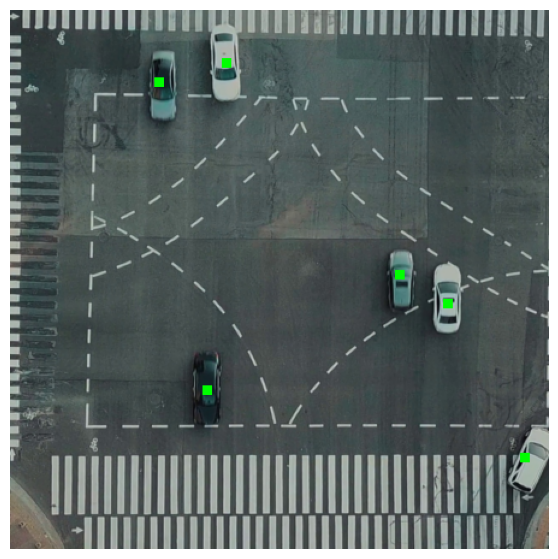

In [57]:
SUBSET = Path("training")
DATA_IDX = 0
CLASS = "car"

class_idx = CLASSES[CLASS]
inspect_dataset = VehicleDataset(
            DATASET_DIR / SUBSET,
            vehicle_data_module._transform,
            vehicle_data_module._target_transform,
)
image, mask, count = inspect_dataset = inspect_dataset[DATA_IDX]
image, mask = convert_from_tensor(image, mask[class_idx])
image[mask == 1] = (0, 255, 0)
plt.figure(figsize = (7,7))
plt.axis('off')
plt.imshow(image)
print(str(count[class_idx]), "object(s) of", CLASS, "class in the picture")

#### Test model results

Predicted 6 from 10 object(s) of car class in the picture


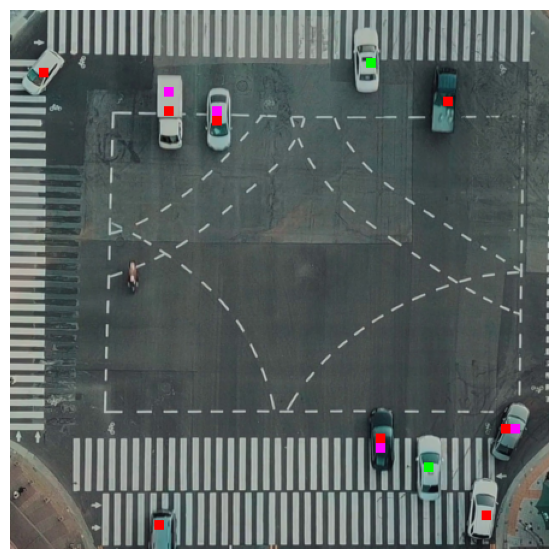

In [58]:
DATA_IDX = 3
CLASS = "car"

class_idx = CLASSES[CLASS]
test_dataset = VehicleDataset(
            DATASET_DIR / Path("test" if TEST_DATASET else "validation"),
            vehicle_data_module._transform,
            vehicle_data_module._target_transform,
)
image, mask, count = test_dataset = test_dataset[DATA_IDX]
with torch.no_grad():
    FOMO_model.eval()
    mask_pred = FOMO_model(image.unsqueeze(0)).cpu()
    mask_processed, cnt_processed = postprocess_prediction(mask_pred, threshold=DETECTION_THRESHOLD)
mask_processed = mask_processed.squeeze(0)

_, mask = convert_from_tensor(image, mask[class_idx])
image, mask_processed = convert_from_tensor(image, mask_processed[class_idx])
image[mask == 1] = (255, 0, 0)
image[mask_processed == 1] = (255, 0, 255)
mask_check = np.logical_and(mask, mask_processed)
image[mask_check == 1] = (0, 255, 0)
plt.figure(figsize = (7,7))
plt.axis('off')
plt.imshow(image)

print("Predicted", str(cnt_processed[class_idx].item()), "from" , str(count[class_idx]), "object(s) of", CLASS, "class in the picture")

## Export model to ONNX

In [38]:
EXPORT_PATH = Path("Models/fomo.onnx")

FOMO_model.to_onnx(
    str(EXPORT_PATH),
    export_params=True,
    input_names=["image"],
    output_names=["masks"],
    input_sample=torch.randn(1, 3, IMAGE_RESOLUTION, IMAGE_RESOLUTION),
)